# Data and Analysis Plan: Understanding Freshman Satisfaction and Retention in Higher Education

- Sahana Dhar
- Madelyn Redick
- Shawn Lokshin

## Project Goal
Our project intends to understand the factors that are associated with a higher number of first-year students returning to a college. We will focus on relationships between a college's retention rate and their other attributes including student population size, average SAT score, and mean net price, among others. More specifically, we ask:
- What aspect is most strongly associated with a high retention rate?
- TODO - other question

## Pipeline Overview:
We webscrape from an [alphabetical list of colleges in the USA](https://www.4icu.org/us/a-z/) to create a list of names of colleges. 
We are using [The College Scorecard API](https://collegescorecard.ed.gov/data/documentation/) from the US Department of Education to obtain our data. This API allows us to get robust data for a specific school. For each school in the list of college names, we will filter desired data from the API into an organized dataframe. 

### Pipeline:

In [32]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

#api_key = 'fK3eae9BKJ8nZKxDTxtAPEXjfi02c3oAhK5aPCdx' #sahana's key
#api_key = 'eNxKT9YQ2JbnD6J2TjemGwcGDOfdKwLutysmZ7YM' #madelyn's key
base_url = 'http://api.data.gov/ed/collegescorecard/v1/schools'

#### Webscraping to get list of schools

In [2]:
# get list of college names
college_names = []
tables = pd.read_html('https://www.4icu.org/us/a-z/')
table_colleges = tables[0]

# flatten table
table_colleges.columns = table_colleges.columns.get_level_values(0)

# access the column names
table_colleges.columns = ['Rank', 'Name', 'Location']

# add each name to list
for college in table_colleges['Name']:
    college_names.append(college)

#### Using the API to get specifc college data

In [3]:
def calculate_mean_tuition(tuition_dict):
    """ calculates the average tution based on in state and out of state tuition

    Arguments:
        tuition_dict (dictionary): contains in state and out of state tuition costs

    Returns:
        tuition (int): final result of averaged tuition
        None: returns None if there are no entries for either in state or out of state tution
    TODO - why are some NaN and some are None"""

    # collect valid values
    valid_values = [value for value in [tuition_dict["in_state"], tuition_dict["out_of_state"]] if value is not None]

    if valid_values:
        # calculate average tuition
        tuition = sum(valid_values) / len(valid_values)
        return tuition
    else:
        return None
    
    
def calculate_diversity(div_dict):
    """TODO - docstring, not sure if this is the best way to do this
    calculates the proportion of students of color"""
    valid_values = [value for key, value in div_dict.items() if value is not None and key != "white" and key != "white_2000"]
    return sum(valid_values)

In [4]:
colleges = college_names[0:100]

# Initialize an empty DataFrame
result_df = pd.DataFrame(columns=['College', 'SAT', 'Earnings 6 yrs after entry', 
                                  'Share First Generation', 'Retention Rate', 'Student Faculty Ratio', 
                                  'Mean Tuition', 'Mean Net Price', 'Size', 'Diversity'])

for college_name in colleges:
    params = {
        'api_key': api_key,
        'school.name': college_name,
    }

    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        
        # Extract the desired data
        try:
            data = data['results'][0]['latest']
            sat_score = data['admissions']['sat_scores']['average']['overall']
            earnings = data['earnings']['6_yrs_after_entry']['median']
            first_gen_percentage = data['student']['share_firstgeneration']
            retention = data['student']['retention_rate']['overall']['full_time']
            student_faculty_ratio = data['student']['demographics']['student_faculty_ratio']
            mean_tuition = calculate_mean_tuition(data['cost']['tuition'])
            mean_net_price = data['cost']['avg_net_price']['overall'] #TODO - not sure if we should use average tuition or mean net price
            size = data['student']['size']
            poc_proportion = calculate_diversity(data["student"]["demographics"]["race_ethnicity"])
            
            # Create a DataFrame for the current college
            data_dict = {
                'College': [college_name],
                'SAT': [sat_score],
                'Earnings 6 yrs after entry': [earnings],
                'Share First Generation': [first_gen_percentage],
                'Retention Rate': [retention],
                'Student Faculty Ratio' : [student_faculty_ratio],
                'Mean Tuition': [mean_tuition],
                'Mean Net Price' : [mean_net_price],
                'Size': [size],
                'Diversity': [poc_proportion]
            }

            college_df = pd.DataFrame(data_dict)

            # Concatenate the college DataFrame to the result_df
            result_df = pd.concat([result_df, college_df], ignore_index=True)
        except (KeyError, IndexError):
            print(f"Data not found for {college_name}")
    else:
        print(f'API request failed with status code: {response.status_code} for {college_name}')

Data not found for A.T. Still University
API request failed with status code: 500 for Anderson University, Indiana
API request failed with status code: 500 for Aquinas College, Tennessee
Data not found for ArtCenter College of Design


In [5]:
result_df

,College,SAT,Earnings 6 yrs after entry,Share First Generation,Retention Rate,Student Faculty Ratio,Mean Tuition,Mean Net Price,Size,Diversity
0,Abilene Christian University,1186,45389,0.244523,0.7923,13,39350.0,29300,3131,0.3659
1,Abraham Baldwin Agricultural College,1026,29825,0.344345,0.6515,19,7018.0,7203,3323,0.1983
2,Academy of Art University,None,31825,0.40837,0.6899,14,25424.0,32736,5294,0.7945
3,Adams State University,1040,36129,0.415131,0.5924,11,13806.5,14305,1484,0.6085
4,Adelphi University,1200,60750,0.354207,0.8296,12,42475.0,28993,5168,0.5436
...,...,...,...,...,...,...,...,...,...,...
91,Barclay College,None,29316,0.403101,0.5,9,23850.0,23840,162,0.3951
92,Bard College,None,30774,0.121711,0.2222,3,48800.0,21650,39,0.7180
93,Bard College at Simon's Rock,None,30774,0.121711,0.7213,6,63583.0,33316,302,0.4636
94,Barnard College,1484,66077,0.15565,0.9749,10,59687.0,32514,3007,0.5893


## Visualizations

The following subplot shows each feature on the vertical axis plotted against retention rate on the horizontal axis in order to get an overview of features that may be more strongly associated with each other. 

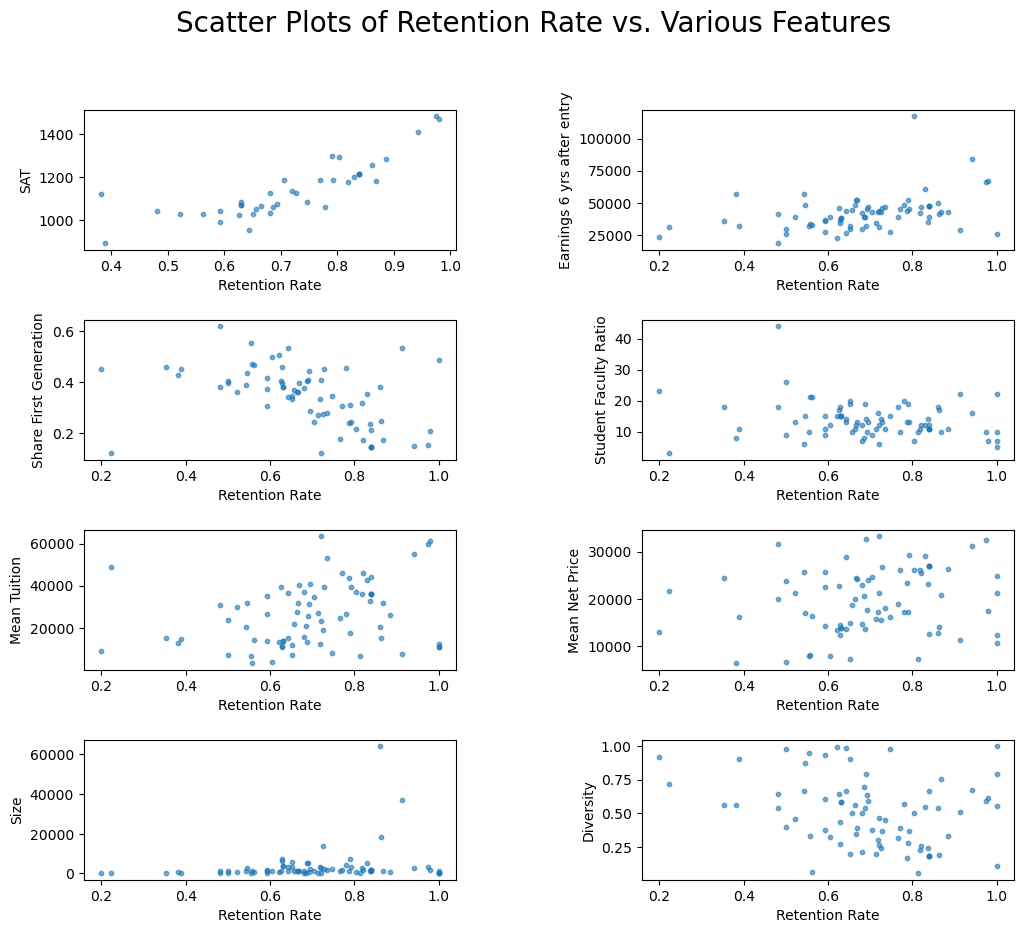

In [75]:
columns = [item for item in result_df.columns if item not in ["Retention Rate", "College"]]

plt.figure(figsize=(12, 10)) 
plt.suptitle("Scatter Plots of Retention Rate vs. Various Features", fontsize=20)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for idx, col in enumerate(columns):
    # activate specifc subplot
    plt.subplot(4, 2, idx+1)

    # plot scatter
    plt.scatter(result_df["Retention Rate"], result_df[col], s=10, alpha=0.6) #, hover_data=["College"],)
    plt.ylabel(col)
    plt.xlabel("Retention Rate")

## Analysis and Machine Learning Plan
